# Image Classification with Convolutional Neural Networks

In image processing, convolution is a mathematical operation performed on an image in order to transform it. An image is convolved with a kernel (a matrix that is usually much smaller than the image, also called filter) by translating the kernel over the image pixel by pixel and replacing each pixel with the sum-product of the filter and the portion of the image it covers.

The kernel can be designed to fulfill a specific transformation such as blurring, sharpening and edge detection.

Convolutional neural networks (CNN) stem from this idea. In a convolutional layer, the input matrix is convolved with a number of kernels to produce a number of output matrices (called feature maps). The key is that the values inside the kernels are not hand-crafted but are weights that are learned instead. Using backpropagation, these weights are updated so that the kernels perform the necessary transformations to produce the desired outputs.

In traditional fully connected networks, every input feature has a weight associated with each neuron in the following layer. In a CNN, the kernel weights are shared among the features. Meaning that we learn a set number of kernel weights regardless of the feature dimensionality. This parameter sharing configuration greatly reduces the number of weights and results in learning position invariant parameters.

CNNs are behind the state-of-the-art advances in computer vision. In this notebook, we will demonstrate the use of CNNs for the simplest computer vision task: image classification.

We will use the [Car-Plane-Ship](https://www.kaggle.com/datasets/abtabm/multiclassimagedatasetairplanecar) classification dataset from Kaggle.

First, you need to create an account on Kaggle, then go to the Account -> Create new API token. You will get a genearted json file which contains the username and the API, you will need both to download the dataset in the cell that follows.

First we will start by downloading the dataset from Kaggle and setting the random seed for reproducibility.

In [1]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/abtabm/multiclassimagedatasetairplanecar")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mariethereseyounan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/abtabm/multiclassimagedatasetairplanecar


100%|██████████| 333M/333M [00:03<00:00, 105MB/s]


In [2]:
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

##1) Data Loading and Preprocessing

The dataset is structured such that every folder represents a class and the images within belong to that class. It is also already split into train and test sets.

We need to create two arrays:
- The X array which contains the images. All images must have the same size so we will resize them to a width and height of 128$\times$128. Keras uses the channel last format which means that the channel dimension will be the last. Since our images are RGB we will have three channels. As a result, every image will have a shape of (128, 128, 3). Also, we normalize the pixel values to be between 0 and 1 by dividing by the maximum pixel value (255). We group all of the images into one array where the first dimension will be the sample size.
- The y array which will have a label for each image in X. The labels will be assigned based on the parent directory.

After exploring the dataset structure, define a function to load and preprocess the data according to the following:
- Read the images into memory. For each image also record its label.
- Resize the width and height of each image to (128, 128). All images must have a uniform shape.
- Handle image exeptions that are not strictly RGB.
- Scale the pixel values.
- Stack the images into a single array X of shape (Number of samples, 128, 128, 3).
- Create an array y of labels.
- Return X and y.

In [3]:
import os
import os.path as osp
import numpy as np
from PIL import Image

def load_data(dir):
    images = []
    labels = []
    for category in os.listdir(dir):
        for image_file in os.listdir(osp.join(dir,category)):
            img = Image.open(osp.join(dir, category, image_file))
            #resize all images to the same width and height
            img = img.resize((128,128))
            #some images in this dataset have 4 channels (RGBA)
            #the "convert" method can handle those
            img = img.convert('RGB')
            #convert from PIL to numpy array with float values between 0 and 1
            img = np.array(img) / 255.0
            images.append(img)
            labels.append(category)
    #X is of shape number_of_samples, 128, 128, 3
    X = np.array(images)
    y = np.array(labels)
    return X, y

- Now call this function for both training and testing sets.

In [4]:
X_train, y_train = load_data('/content/multiclassimagedatasetairplanecar/Dataset/train')
X_test, y_test = load_data('/content/multiclassimagedatasetairplanecar/Dataset/test')

y_train[y_train == 'ship'] = 'ships'

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3000, 128, 128, 3) (3000,)
(582, 128, 128, 3) (582,)


- Convert the y arrays from string to one-hot encoding format.

In [5]:
from sklearn.preprocessing import LabelBinarizer

#initialize the Label Binarizer
encoder = LabelBinarizer()

#convert the training and testing labels to onehot encoding
y_train_onehot = encoder.fit_transform(y_train)
y_test_onehot = encoder.transform(y_test)
#print the shapes of the new onehot encoded labels
print('Shape of y_train_onehot:', y_train_onehot.shape)
print('Shape of y_test_onehot:', y_test_onehot.shape)

print(X_train.shape, y_train_onehot.shape)
print(X_test.shape, y_test_onehot.shape)

Shape of y_train_onehot: (3000, 3)
Shape of y_test_onehot: (582, 3)
(3000, 128, 128, 3) (3000, 3)
(582, 128, 128, 3) (582, 3)


#2) Data Exploration

- Explore the dataset by displaying a number of images along with their labels.

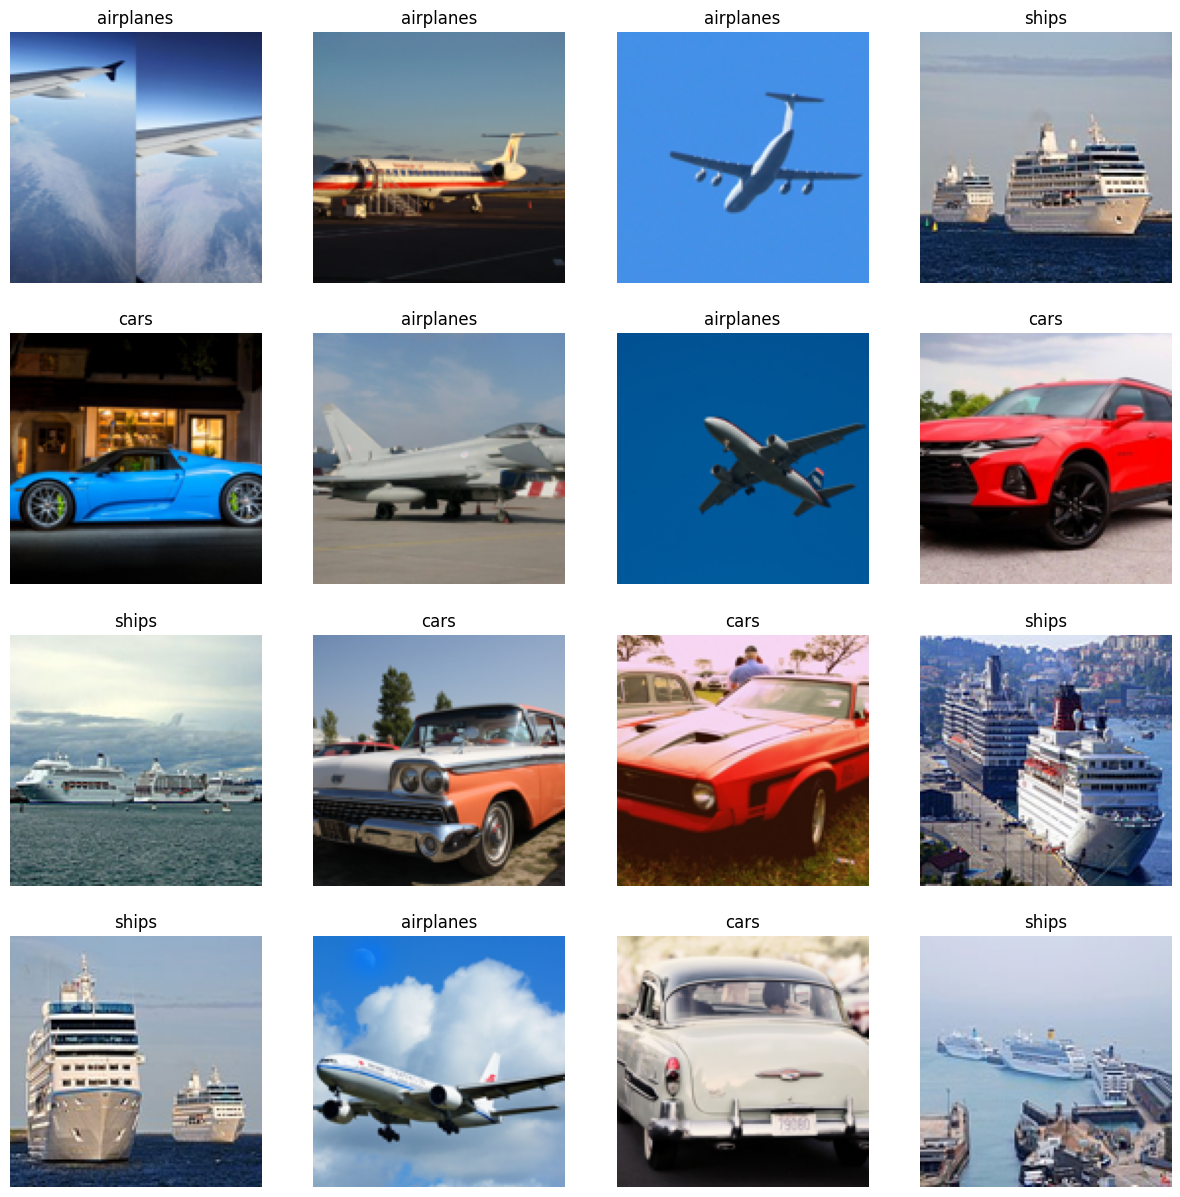

In [6]:
import matplotlib.pyplot as plt
#lets first do an array of indices and shuffle them
indices = np.arange(len(X_train))
np.random.shuffle(indices)
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.axis('off')
    plt.imshow(X_train[indices[i]])  #display the ith image at the shuffled index
    #the title should display the label at the shuffled index
    plt.title(y_train[indices[i]])
plt.show()

#3) Neural Network

Before we jump into building our first CNN, let's try to use a fully connected network for our image classification.

We will build a traditional multiclass classification network comprised of stacked dense layers and ending with a softmax layer.

The only difference that needs to be taken into account is that a dense network expects features to be arranged in a one-dimensional array. In the case of images, every pixel is a feature but they are arranged in a two-dimensional structure. Therefore, we need to flatten the images into 1D arrays when inputting then into the network. This can be easily done by adding a "Flatten" layer at the beginning of our network. The "Flatten" layer is a Keras layer that does not learn any weights but simply flattens its input into 1D.

- Build a fully connected neural network.
- Train it on the data and show the training and validation loss curves.
- Play with the different hyperparameters (number of layer, number of neurons, optimizer, regularization, epochs, batch size...) until you obtain a satisfactory performance.

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

model = Sequential([
    Flatten(input_shape=(128, 128, 3)),  #flatten the images to a 1D array
    Dense(512, activation='relu'),       #first dense layer
    Dropout(0.3),                        #dropout layer for regularization
    Dense(256, activation='relu'),       #second dense layer
    Dropout(0.3),                        #second dropout
    Dense(3, activation='softmax')       #output layer with softmax for multi-class classification
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
75/75 [==============================] - 5s 20ms/step - loss: 9.5068 - accuracy: 0.4383 - val_loss: 1.8944 - val_accuracy: 0.2633
Epoch 2/10
75/75 [==============================] - 1s 15ms/step - loss: 1.0981 - accuracy: 0.4704 - val_loss: 1.3902 - val_accuracy: 0.0917
Epoch 3/10
75/75 [==============================] - 1s 14ms/step - loss: 0.9978 - accuracy: 0.4629 - val_loss: 0.7681 - val_accuracy: 0.6550
Epoch 4/10
75/75 [==============================] - 1s 15ms/step - loss: 1.0031 - accuracy: 0.4487 - val_loss: 1.5940 - val_accuracy: 0.0233
Epoch 5/10
75/75 [==============================] - 1s 15ms/step - loss: 1.0060 - accuracy: 0.4375 - val_loss: 1.0548 - val_accuracy: 0.4700
Epoch 6/10
75/75 [==============================] - 1s 18ms/step - loss: 1.0024 - accuracy: 0.4225 - val_loss: 1.8564 - val_accuracy: 0.0117
Epoch 7/10
75/75 [==============================] - 1s 18ms/step - loss: 0.9986 - accuracy: 0.4175 - val_loss: 1.4556 - val_accuracy: 0.2517
Epoch 8/10
75

- Compute the following evaluation metrics on the test set: accuracy, precision, recall and F1-score.

In [8]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_onehot, axis=1)
#generate a classification report
print(classification_report(y_test_classes, y_pred_classes))

19/19 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.17      0.02      0.03       189
           1       0.96      0.12      0.21       193
           2       0.37      1.00      0.54       200

    accuracy                           0.39       582
   macro avg       0.50      0.38      0.26       582
weighted avg       0.50      0.39      0.27       582



#4) Convolutional Neural Network

Our fully connected network did not provide very impressive results. We will improve our results by switching to a convolutional architecture.

The main components of the network will be the Conv2D and MaxPooling2D layers.
- The Conv2D performs the two dimensional convolution previously described. The essential hyperparameters to specify are "filters" which is the number of filters to learn and therefore the number of output feature maps and "kernel_size" which indicates the kernel width and height. There are other more advanced configurations to tweak such as strides, padding and dilation.
- Max pooling uses a kernel similarly to convolution. However, this kernel does not have weights and simply performs the max operation over the pixels. Max pooling is a technique used to summarize the feature maps after convolution to select only the most important features while reducing the size of the feature maps. Similarly to "kernel_size", "pool_size" indicates the size of the pooling kernel.

Multiple convolutional and pooling layers can be stacked but eventually, we need a dense layer to produce our class predictions. As explained before, the dense layer needs to be preceded by a flatten layer.

- Repeat the same steps as Question 3 but using a convolutional neural network.

In [27]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential([
    #first Convolutional layer
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding ='same', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    #second convolutional layer
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    #flatten the 3D result to 1D
    Flatten(),
    Dense(10, activation='relu'),
    Dropout(0.5),
    #output layer with softmax
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train_onehot, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
75/75 [==============================] - 3s 27ms/step - loss: 1.0364 - accuracy: 0.4146 - val_loss: 0.8633 - val_accuracy: 0.5217
Epoch 2/10
75/75 [==============================] - 1s 20ms/step - loss: 0.9691 - accuracy: 0.4654 - val_loss: 0.7693 - val_accuracy: 0.7767
Epoch 3/10
75/75 [==============================] - 1s 20ms/step - loss: 0.9048 - accuracy: 0.4808 - val_loss: 0.7604 - val_accuracy: 0.8017
Epoch 4/10
75/75 [==============================] - 1s 19ms/step - loss: 0.9052 - accuracy: 0.4888 - val_loss: 0.8779 - val_accuracy: 0.6950
Epoch 5/10
75/75 [==============================] - 1s 19ms/step - loss: 0.8608 - accuracy: 0.5158 - val_loss: 0.7411 - val_accuracy: 0.7017
Epoch 6/10
75/75 [==============================] - 2s 23ms/step - loss: 0.8353 - accuracy: 0.5667 - val_loss: 0.4929 - val_accuracy: 0.8500
Epoch 7/10
75/75 [==============================] - 2s 22ms/step - loss: 0.8127 - accuracy: 0.6042 - val_loss: 0.5715 - val_accuracy: 0.7750
Epoch 8/10
75

In [28]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  #convert predicted probabilities to class labels
y_test_classes = np.argmax(y_test_onehot, axis=1)  #convert onehot encoded true labels back to class labels

#print the classification report which includes precision, recall, f1-score, and accuracy
print(classification_report(y_test_classes, y_pred_classes))

19/19 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       189
           1       0.92      0.82      0.87       193
           2       0.85      0.94      0.89       200

    accuracy                           0.85       582
   macro avg       0.85      0.85      0.85       582
weighted avg       0.85      0.85      0.85       582



##5) Transfer Learning

There is a clear advantage and improvement with the CNN compared to the fully connected network. But can we do better?

We can try to experiment with different CNN configurations and optimize hyperparatmeters. But there is a quicker way.

The ImageNet Large Scale Visual Recognition Challenge is an image classification and object detection challenge that led to a revolution in the computer vision field.

Every iteration of this challenge has led to the development of novel CNN architectures that became state-of-the-art in visual recognition tasks. These networks are very large and were trained on very large data for long durations. Additionally, most them introduced new mechanics such as residual connections and inception modules.

Luckily, these networks along with their learned weights are publicly available. Transfer learning is a technique that uses a pre-trained model and fine tunes it on different yet similar task.

For our task, we will load Inception, which is an Imagenet model and fine tune it. Imagenet has 1000 output classes but our dataset has only 3. So we will cut the last dense layer from Inception and replace it with our own.
Additionally, we will freeze all the pre-trained Inception weights since they already learned very robust image representation on Imagenet and only train the dense layer we added.

- Load the InceptionV3 network without the top (last) dense layer. Set the pooling operation performed after the last convolution to max pooling.
- Create your own dense layer for classification and link it to the output of the Inception model using the Keras Functional API.
- Set the Inception weights to be non-trainable.
- Train and evaluate the model as before.

In [29]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session
clear_session() #clear any previous session
#create the pre-trained model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3), pooling='max')

#add a dense and softmax layer using the Functional API
x = inception_model.output
x = Dense(128, activation='relu')(x)  #add the dense layer
predictions = Dense(3, activation='softmax')(x)  #output layer with 3 classes

#full model
model = Model(inputs=inception_model.input, outputs=predictions)

#freeze all InceptionV3 layers
#this means that the gradient will not be computed for these weights
#and they will not be updates
for layer in inception_model.layers:
    layer.trainable = False
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 [==============================] - 3s 0us/step


In [30]:
from sklearn.metrics import classification_report

#train the model
history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_test, y_test_onehot))

#after training, make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  #convert predicted probabilities to class labels
y_test_classes = np.argmax(y_test_onehot, axis=1)  #convert onehot encoded true labels back to class labels

#generate a classification report
print(classification_report(y_test_classes, y_pred_classes))

Epoch 1/10
94/94 [==============================] - 16s 91ms/step - loss: 0.2805 - accuracy: 0.9373 - val_loss: 0.0865 - val_accuracy: 0.9828
Epoch 2/10
94/94 [==============================] - 3s 35ms/step - loss: 0.0403 - accuracy: 0.9880 - val_loss: 0.1317 - val_accuracy: 0.9725
Epoch 3/10
94/94 [==============================] - 3s 35ms/step - loss: 0.0221 - accuracy: 0.9947 - val_loss: 0.0713 - val_accuracy: 0.9845
Epoch 4/10
94/94 [==============================] - 3s 33ms/step - loss: 0.0134 - accuracy: 0.9963 - val_loss: 0.1161 - val_accuracy: 0.9828
Epoch 5/10
94/94 [==============================] - 3s 35ms/step - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.1343 - val_accuracy: 0.9794
Epoch 6/10
94/94 [==============================] - 3s 36ms/step - loss: 0.0083 - accuracy: 0.9970 - val_loss: 0.0907 - val_accuracy: 0.9897
Epoch 7/10
94/94 [==============================] - 3s 36ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0940 - val_accuracy: 0.9897
Epoch 8/10
9

#6) Model Inference

- Download an image from the Internet and use your model to classify the image.

In [31]:
#the trained model is named 'model'
model.save('my_model.h5')  #saves the model to the Colab VM's local file system

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
!ls  #list all files in the current directory

multiclassimagedatasetairplanecar  my_model.h5	sample_data


In [33]:
from tensorflow.keras.models import load_model

model = load_model('my_model.h5')

In [34]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import requests
from PIL import Image
from io import BytesIO

#load the trained model
model = load_model('my_model.h5')

#url of the image we want to download and classify
image_url = 'https://images.pexels.com/photos/170811/pexels-photo-170811.jpeg?cs=srgb&dl=pexels-mikebirdy-170811.jpg&fm=jpg'

#download the image
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

#preprocess the image to fit the model's input requirements
img = img.resize((128, 128))  #resize to the same size as model training
img = img.convert('RGB')
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

#perform inference
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)  #Assuming the model uses categorical output

class_names = ['airplanes', 'cars', 'ships']
predicted_class_name = class_names[predicted_class[0]]

print("Predicted class:", predicted_class_name)

1/1 [==============================] - 3s 3s/step
Predicted class: cars
